In [1]:
import numpy as np
from Models import diffusion_advection
from scipy.optimize import least_squares
from Simulation import simulate
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.stats import loguniform

In [2]:
# Fast model using njit
# Model code to run 
import numpy as np
from collections import namedtuple

params = namedtuple('params', ["b_u", "b_l", "g", "c", "d", "p_u", "p_l", "gamma", "k", "f", "r", "D", "a"])
def model(y, t, p):
    # Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
    # States are U1, E1, I1, V1, U2, E2, I2, V2, X
    p = params(*p)
    dydt = np.zeros(len(y)) + 0.0
    #dSu/dt = beta_u*Su*Vu
    dydt[0] = - p.b_u*y[0]*y[3]
    #dEu/dt = beta_u*Su*Vu - g*Eu
    dydt[1] = p.b_u*y[0]*y[3] - p.g*y[1]
    #dIu/dt = g*Eu - d*Iu
    dydt[2] = p.g*y[1] - p.d*y[2]
    #dVu/dt = p_u*Iu - c*Vu - gamma*beta_u*Su*Vu - D*(Vu-Vl) + a*Vl
    dydt[3] = p.p_u*y[2] - p.c*y[3] - p.gamma*p.b_u*y[0]*y[3] - p.D*(y[3]-y[7]) + p.a*y[7]
    #dSl/dt = -beta_l*Sl*Vl
    dydt[4] = - p.b_l*y[4]*y[7]
    #dEl/dt = beta_l*Sl*Vl - g*El
    dydt[5] = p.b_l*y[4]*y[7] - p.g*y[5]
    #dIl/dt = g*El - d*Il
    dydt[6] = p.g*y[5] - p.d*y[6]
    #dVl/dt = p_l*Il - c*Vl - gamma*beta_l*Sl*Il - k*Vl*X + D*(Vu-Vl) - a*Vl
    dydt[7] = p.p_l*y[6] - p.c*y[7] - p.gamma*p.b_l*y[4]*y[7] - p.k*y[7]*y[8] + p.D*(y[3]-y[7]) - p.a*y[7]
    #dX/dt = f*Vl + r*X
    dydt[8] = p.f*y[7] + p.r*y[8]
    return dydt

In [3]:
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
p = [1.5e-8, 1.5e-6, 4, 2, 5.2, 5e7/(Cell_Count_U), 5e7/(Cell_Count_L), 0, 20, 0.56*2.8e-6 / 7, 0.27 / 7, 0.01, 0.1]

In [4]:
def sol_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,7.68,7.85,7.73,7.01,6.073,4.45,5.894,5.5356,4.325,3.959,6.548])
    return y - Lresults

def log_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,  7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
    return np.log(y)-np.log(Lresults)

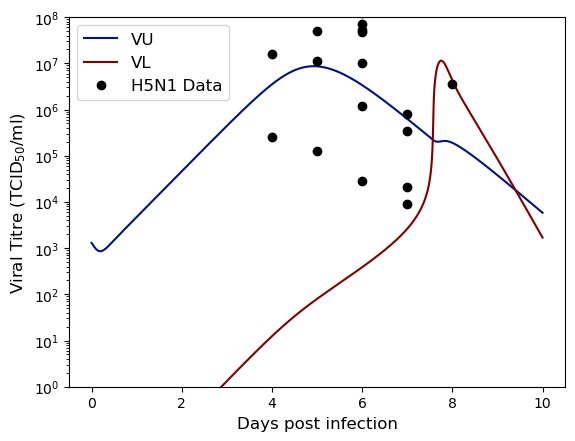

Objective: 69.15515150821714
Parameters: [3.43180232e-07 4.28243593e-04 4.97645667e-01 9.94618431e-02
 1.09834745e-02 2.11864002e-02 2.06201087e-02]


In [15]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.1,1e-5,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

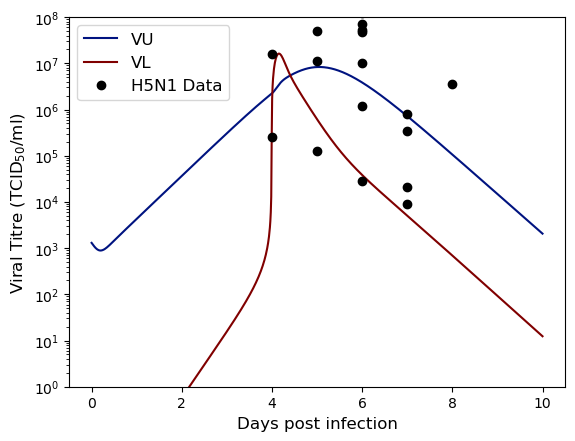

Objective: 70.96791248871682
Parameters: [3.21343042e-07 8.71109626e-03 4.64124424e-01 1.11647607e-01
 7.37113159e-03 1.97911068e-01 1.99606058e-01]


In [35]:
testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
# testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.1,1e-3,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

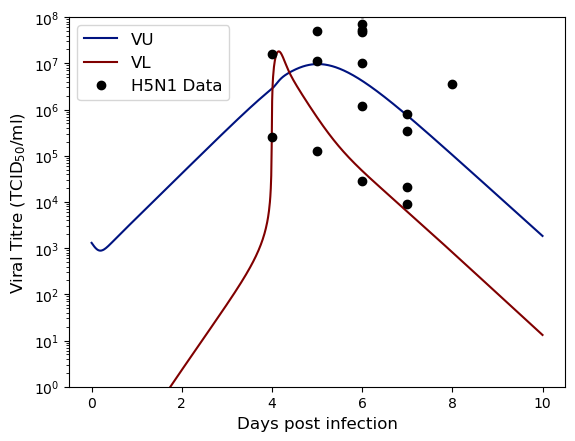

Objective: 70.82459666441456
Parameters: [2.82629428e-07 2.30677515e-03 5.54184666e-01 1.29961768e-01
 8.68853401e-03 2.57268247e-01 7.05760438e-02]


In [34]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.1,1e-3,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

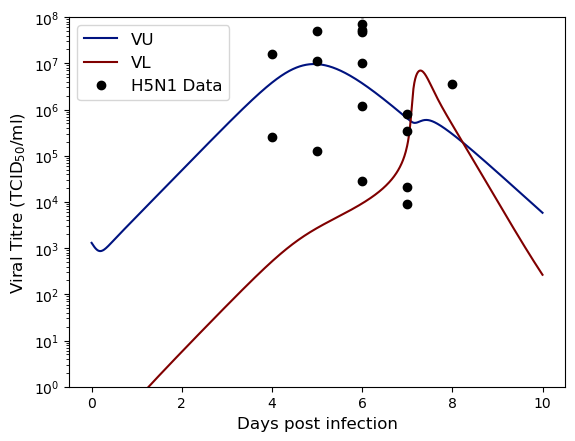

Objective: 67.55974219962987
Parameters: [2.90929150e-07 6.44959323e-05 5.88235205e-01 7.69286165e-02
 1.09187352e-02 2.15409340e-01 1.94858557e-02]


In [18]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [3e-07,2e-06,0.5,0.01,1e-5,0.02,0.02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

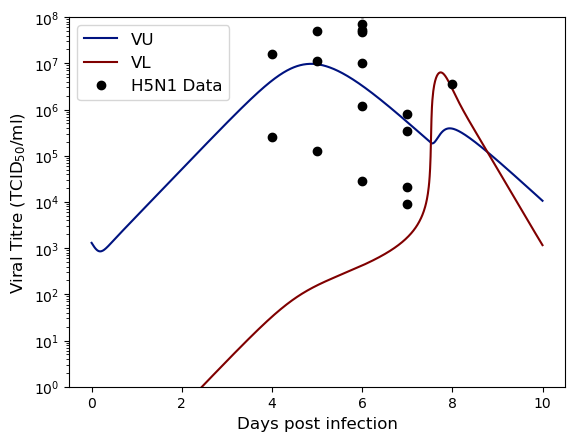

Objective: 66.51648073204157
Parameters: [3.02707135e-07 9.58567813e-04 5.88332021e-01 7.70605939e-02
 1.16370064e-02 2.15406375e-01 1.95286359e-02]


In [24]:
# testu = least_squares(log_minimiser_vu, [1.5e-8,1.5e-6,5e7/(Cell_Count_U),5e7/(Cell_Count_L),0,0.01,0.1],bounds=(0,np.inf))
testu = least_squares(log_minimiser_vu, [2.90929150e-07,6.44959323e-05,5.88235205e-01,7.69286165e-02,1.09187352e-02,2.15409340e-01,1.94858557e-02],bounds=(0,np.inf))

Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
ts = np.linspace(0, 10, 1000)

inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
# Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
# States are U1, E1, I1, V1, U2, E2, I2, V2, X
theta = testu.x
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))

x = np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
plt.semilogy(ts, results[:,3], label="VU", color="#001380")
plt.semilogy(ts, results[:,7], label="VL", color="#800000")
plt.semilogy(x, y, "o", color='k', label="H5N1 Data")
plt.xlabel("Days post infection", fontsize=12)
plt.ylabel(r"Viral Titre (TCID$_{50}$/ml)", fontsize=12)
plt.legend(fontsize=12)
plt.ylim([10**0,10**8])
plt.show()
print(f"Objective: {testu.cost}")
print(f"Parameters: {testu.x}")

In [17]:
np.sum(log_minimiser_vu(param_set[1])**2)

182.96282914533924

In [18]:
param_set = np.genfromtxt('log_adaptive_6.csv',skip_header=1,delimiter=',')
errs = np.zeros(len(param_set))
for i in range(len(param_set)):
    errs[i] = np.sum(log_minimiser_vu(param_set[1])**2)

In [24]:
param_set[0]

array([2.63973170e-07, 8.84841183e-06, 4.83679229e-01, 1.54315183e-02,
       3.43769676e-04, 6.12923085e-02, 7.09423758e-02])

In [25]:
errs[0]

182.96282914533924

In [20]:
etol = np.quantile(errs,0.4)
print(etol)

182.96282914533924


In [ ]:
  ICs <- c("Tu" = 4e8,"Eu"=0,"Iu"=0,"Vu"=1.3e3,"Tl"=6.25e9,"El"=0,"Il"=0,"Vl"=0,"X"=0)
  para <- list("bu" = theta[1], "bl" = theta[2], "g" = 4, "c" = 2, "d" = 5.2, "pu" = theta[3], 
               "pl" = theta[4], "gamma" = theta[5], "k" = 20, "f" = 0.56*2.8e-7/7, 
               "r" = 0.27/7, "D"=theta[6], "a"=theta[7])
  ts <- c(401,401,501,501,501,501,  601,601,601,601,601,601,601   ,701,701,701,701,801)
  Classes <- ODE_host_model(para, ICs)
  mresults <- Classes$Vu[ts]
  y = 10^c(7.2,5.40,5.1,7.05,7.7,8.14,  7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548)
  return(sum((log(y)-log(mresults))^2))

In [26]:
theta = param_set[0]

In [27]:
Cell_Count_U = 4e8
Cell_Count_L = 6.25e9
inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
ts = np.linspace(0,10,1001)
x = 100 * np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
Lresults = results[x,3]

In [40]:
# Model code to run 
import numpy as np
from collections import namedtuple

params = namedtuple('params', ["b_u", "b_l", "g", "c", "d", "p_u", "p_l", "gamma", "k", "f", "r", "D", "a"])
def model(y, t, p):
    # Parameters b_u, b_l, g, c, d, p_u, p_l, gamma, k, f, r, D, a
    # States are U1, E1, I1, V1, U2, E2, I2, V2, X
    p = params(*p)
    dydt = np.zeros(len(y)) + 0.0
    #dSu/dt = beta_u*Su*Vu
    dydt[0] = - p.b_u*y[0]*y[3]
    #dEu/dt = beta_u*Su*Vu - g*Eu
    dydt[1] = p.b_u*y[0]*y[3] - p.g*y[1]
    #dIu/dt = g*Eu - d*Iu
    dydt[2] = p.g*y[1] - p.d*y[2]
    #dVu/dt = p_u*Iu - c*Vu - gamma*beta_u*Su*Vu - D*(Vu-Vl) + a*Vl
    dydt[3] = p.p_u*y[2] - p.c*y[3] - p.gamma*p.b_u*y[0]*y[3] - p.D*(y[3]-y[7]) + p.a*y[7]
    #dSl/dt = -beta_l*Sl*Vl
    dydt[4] = - p.b_l*y[4]*y[7]
    #dEl/dt = beta_l*Sl*Vl - g*El
    dydt[5] = p.b_l*y[4]*y[7] - p.g*y[5]
    #dIl/dt = g*El - d*Il
    dydt[6] = p.g*y[5] - p.d*y[6]
    #dVl/dt = p_l*Il - c*Vl - gamma*beta_l*Sl*Il - k*Vl*X + D*(Vu-Vl) - a*Vl
    dydt[7] = p.p_l*y[6] - p.c*y[7] - p.gamma*p.b_l*y[4]*y[7] - p.k*y[7]*y[8] + p.D*(y[3]-y[7]) - p.a*y[7]
    #dX/dt = f*Vl + r*X
    dydt[8] = p.f*y[7] + p.r*y[8]
    return dydt

In [42]:
model(inits, 0, p)

array([-1.37266048e+05,  1.37266048e+05,  0.00000000e+00, -2.72686791e+03,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  7.96800010e+01,
        0.00000000e+00])

In [38]:
np.max(results[:,3])

8815099.268655537

In [37]:
ts[458]

4.58

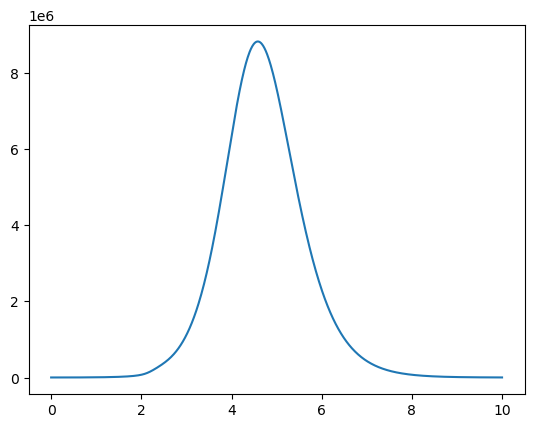

In [33]:
plt.plot(ts,results[:,3])

In [ ]:
def log_minimiser_vu(theta):
    Cell_Count_U = 4e8
    Cell_Count_L = 6.25e9
    inits = np.array([Cell_Count_U, 0, 0, 1.3e3, Cell_Count_L, 0, 0, 0, 0])
    p = [theta[0], theta[1], 4, 2, 5.2, theta[2], theta[3], theta[4], 20, 0.56*2.8e-6 / 7, 0.27 / 7, theta[5], theta[6]]
    ts = np.linspace(0,10,1001)
    x = 100 * np.array([4,4,5,5,5,5,6,6,6,6,6,6,6,7,7,7,7,8])
    results = simulate.solve_model(diffusion_advection.model, inits, ts, (p,))
    Lresults = results[x,3]
    y = 10**np.array([7.2,5.40,5.1,7.05,7.7,8.14,  7.68,7.85,7.73,7.01,6.073,4.45,8.08,5.894,5.5356,4.325,3.959,6.548])
    return np.log(y)-np.log(Lresults)